In [17]:
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import cv2
print(f"device: {device}")

device: cuda


In [10]:
# Define Mongolian Unicode vocabulary
vocab = list(range(0x1800, 0x180F)) + list(range(0x1810, 0x181A)) + list(range(0x1820, 0x1879)) + \
        list(range(0x1880, 0x18AB)) + [0x202F]

vocab = ["<blank>", "<pad>", " "] + [chr(v) for v in vocab]  # <blank> token at index 0

# Create character-to-index mappings
idx2char = {idx: char for idx, char in enumerate(vocab)}
char2idx = {char: idx for idx, char in idx2char.items()}

# Add <unk> token for unknown characters
n = len(idx2char)
idx2char[n] = "<unk>"
char2idx["<unk>"] = n

# Add other special characters
idx2char[n+1] = '?'
char2idx['?'] = n+1
char2idx['︖'] = n+1
char2idx['？'] = n+1

# Define padding token
PAD_TOKEN = 1  # Common choice for PyTorch loss functions

# Text to IDs function with <unk> for unknown characters
def text_to_ids(text, max_length=None):
    ids = [char2idx.get(char, char2idx["<unk>"]) for char in text]  # Use <unk> for unknown chars
    
    if max_length is not None:
        if len(ids) < max_length:
            ids += [PAD_TOKEN] * (max_length - len(ids))  # Pad the sequence
        else:
            ids = ids[:max_length]  # Truncate the sequence if it's too long

    return ids

# IDs to text function
def ids_to_text(ids):
    decoded_text = []
    for idx in ids:
        if idx == 0:
            continue  # Ignore blank token (<blank>)
        elif idx > 0:  # For other characters in the vocab
            decoded_text.append(idx2char.get(idx, ''))  # Avoid missing chars

    return "".join(decoded_text)
def load_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '=' not in line:
                continue
            key, value = line.split('=')
            key = key.strip()
            value = value.strip().lower().replace('0x', '')
            mapping[key] = chr(int(value, 16))
    return mapping

# Load your map
mapping = load_mapping('mapping.txt')

In [13]:
def decode_predictions(predictions):
    """
    Decode model predictions to text strings.
    
    Args:
        predictions: Tensor of indices
    
    Returns:
        List of decoded strings
    """
    texts = []
    for pred in predictions:
        # Get the highest probability character at each timestep
        pred_indices = torch.argmax(pred, dim=1).cpu().numpy()
        
        # Remove repeated characters
        collapsed = []
        prev = -1
        for p in pred_indices:
            if p != prev and p != 0:  # Skip blanks
                collapsed.append(p)
            prev = p
        
        # Convert indices to characters
        text = ''.join([idx2char.get(idx, '') for idx in collapsed if idx != 1])  # Skip pad tokens
        texts.append(text)
    return texts

def calculate_wer(reference, hypothesis): #new to be tried later
    """
    Calculate Word Error Rate (WER) using dynamic programming.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Word Error Rate as a float
    """
    total_words = 0
    total_errors = 0

    for ref, hyp in zip(reference, hypothesis):
        ref_words = ref.split()
        hyp_words = hyp.split()
        total_words += len(ref_words)

        # Initialize DP table
        dp = [[0] * (len(hyp_words) + 1) for _ in range(len(ref_words) + 1)]

        # Fill first row and column
        for i in range(len(ref_words) + 1):
            dp[i][0] = i  # Deletions
        for j in range(len(hyp_words) + 1):
            dp[0][j] = j  # Insertions

        # Compute edit distance
        for i in range(1, len(ref_words) + 1):
            for j in range(1, len(hyp_words) + 1):
                if ref_words[i - 1] == hyp_words[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1]  # No change
                else:
                    dp[i][j] = 1 + min(
                        dp[i - 1][j],    # Deletion
                        dp[i][j - 1],    # Insertion
                        dp[i - 1][j - 1] # Substitution
                    )

        # Final WER count
        total_errors += dp[-1][-1]  # Minimum edit distance

    return total_errors / total_words if total_words > 0 else 0


def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate without external libraries.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Character Error Rate as a float
    """
    total_chars = 0
    char_errors = 0
    
    for ref, hyp in zip(reference, hypothesis):
        total_chars += len(ref)
        
        # Simplified Levenshtein distance calculation
        # Initialize matrix
        matrix = [[0 for _ in range(len(hyp) + 1)] for _ in range(len(ref) + 1)]
        
        # Initialize first row and column
        for i in range(len(ref) + 1):
            matrix[i][0] = i
        for j in range(len(hyp) + 1):
            matrix[0][j] = j
        
        # Fill matrix
        for i in range(1, len(ref) + 1):
            for j in range(1, len(hyp) + 1):
                if ref[i-1] == hyp[j-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(
                        matrix[i-1][j] + 1,      # deletion
                        matrix[i][j-1] + 1,      # insertion
                        matrix[i-1][j-1] + 1     # substitution
                    )
        
        char_errors += matrix[len(ref)][len(hyp)]
    
    return char_errors / total_chars if total_chars > 0 else 0


In [11]:
class CRNN(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=256, dropout_rate=0.25):
        """
        Initializes the CRNN model with added dropout layers.
        
        :param input_channels: Number of input channels (e.g., 1 for grayscale).
        :param hidden_dim: Hidden dimension size for the RNN.
        :param dropout_rate: Dropout rate for preventing overfitting.
        """
        super(CRNN, self).__init__()
        self.num_classes = len(idx2char)  # Number of output classes

        # CNN feature extractor with dropout
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)

        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.batchnorm7 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))

        # Dropout after CNN layers
        self.dropout_cnn = nn.Dropout2d(dropout_rate)

        # BiLSTM for sequence modeling
        self.rnn = nn.LSTM(input_size=512 * 1, hidden_size=hidden_dim, num_layers=4,
                           bidirectional=True, batch_first=True)

        # Dropout after BiLSTM
        self.dropout_rnn = nn.Dropout(dropout_rate)

        # Fully connected layer to map RNN outputs to num_classes
        self.fc = nn.Linear(hidden_dim * 2, self.num_classes)  # *2 for bidirectional

        # Dropout after the fully connected layer
        # self.dropout_fc = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass.
        
        :param x: Input image tensor of shape (batch_size, channels, height, width)
        :return: Logits of shape (batch_size, seq_length, num_classes)
        """
        # Convolutional feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(F.relu(self.conv4(x)))
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool4(F.relu(self.conv6(x)))
        x = F.relu(self.batchnorm7(self.conv7(x)))

        # Dropout after CNN layers
        x = self.dropout_cnn(x)

        # Reshape to fit into RNN
        b, c, h, w = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch_size, width, channels, height)
        x = x.reshape(b, w, c * h)  # Flatten channels and height

        # Pass through BiLSTM
        rnn_out, _ = self.rnn(x)

        # Dropout after RNN
        rnn_out = self.dropout_rnn(rnn_out)

        # Fully connected layer for character prediction
        logits = self.fc(rnn_out)  # Shape: (batch_size, seq_length, num_classes)

        # Dropout after the fully connected layer
        # logits = self.dropout_fc(logits)

        return logits


In [24]:
model = CRNN(input_channels=1, hidden_dim=512)
model.load_state_dict(torch.load('../../downloaded/model/crnn_big_printed_mix_400k_15_25_epoch.pth'))
model = model.to(device)  # Make sure the model is on the correct device

C:\Users\home\AppData\Local\Temp\ipykernel_19476\4262032282.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../downloaded/model/crnn

['ᠲᠠᠮᠦᠵᠢᠨ']

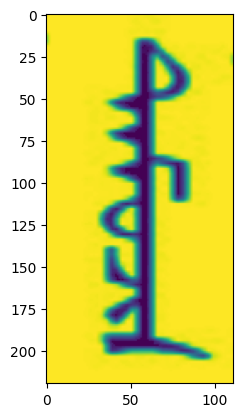

In [46]:
image_path = '../../dataset/real_life/book/processed/images/word_009.png'
# image_path = 'test_images/test4.png'
# image = Image.open(image_path)

gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# gray = cv2.rotate(gray, cv2.ROTATE_90_COUNTERCLOCKWISE)
# gray = st.estimate_vertical_skew_and_draw(gray)
# Binarize the image (invert to make text=1, background=0)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary = 255-binary
binary_pil = Image.fromarray(binary)

input_shape = (32, 256)
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.rotate(90, expand=True)),  # Rotate 90 degrees
    transforms.Resize(input_shape),
    transforms.Grayscale(num_output_channels=1),  # Converts to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),  # Adjusted to single channel
])
input_tensor = transform(binary_pil)
input_tensor = input_tensor.unsqueeze(0).to(device)  # Move to CUDA
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_tensor)
pred_texts = decode_predictions(output)
plt.imshow(gray)
pred_texts

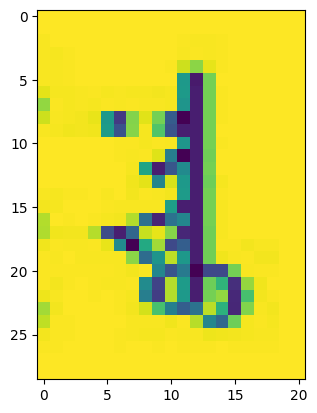

In [29]:
plt.imshow(gray)